# name: Marco Giunta
## Rlab04

In [7]:
library(tidyverse)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



# Exercise 1: six boxes toy model - inference (i.e. with user input)
This exercise is a straightforward application of the Bayes theorem in the context of Bayesian inference.     
We know Bayes theorem can be expressed in words as follows:
\begin{equation}
  \text{posterior} = \frac{\text{likelihood}\times{\text{prior}}}{\text{evidence}}
\end{equation}
which can be made a bit more explicit as follows:
\begin{equation}
  p(\text{model}_i|\text{data}) = \frac{p(\text{data}|\text{model}_i) p(\text{model}_i)}{p(\text{data})} \quad \text{where} \ p(\text{data}) = \sum_i p(\text{data}|\text{model}_i) p(\text{model}_i)
\end{equation}

The above equations are fully general in the sense that $\text{model}_i$ is a set of parameters of an abstract model and $\text{data}$ refers to a (potentially multi-dimensional) outcome of a generic experiment; how do these translate in our six boxes experiment? We notice that:     
1) *Model*: The hypotesis wrt which we carry out the inference is simply the content of the box picked at the beginning of the experiment, starting from the 6 possible ones. This means that the model is fully parametrized by the index $i$ of the box i.e. by the number of white beads inside the box; hence we have a 1-D inference of this single parameter.     
2) *Data*: In the six boxes experiment we extract one bead at a time by picking it at random (with replacement) from the box. Since at each time step we extract a single bead "data" in our case simply means the color of the extracted stone, i.e. "white" or "black". This means that any given extraction/event ccan be parametrized by $k = \text{white}/\text{black}$; our inference is completely 1-D, then, and no marginalization will be needed.

In [122]:
compute.posterior <- function(prior, data) { # B.T.
    likelihood <- abs(data - 0:5/5)
    likelihood.times.prior <- likelihood*prior
    evidence <- sum(likelihood.times.prior)
    posterior <- likelihood.times.prior/evidence
    return (posterior)
}

In [2]:
get.user.input <- function() {
    input <- readline(prompt = 'enter extracted color ("w" or "b") or "stop" ')
    if (input == "w") x <- 0
    else {
        if (input == "b") x <- 1
        else x <- NA
    }
    if (input == "stop") proceed <- FALSE
    else proceed <- TRUE
    
    return (c(x, proceed))
}

In [132]:
plot.posterior <- function(posterior, index) {
    df.ggplot <- data.frame(0:5, posterior)
    names(df.ggplot) <- c("hypothesis", "posterior")
    ggplot(data = df.ggplot, aes(x = hypothesis, y = posterior)) + geom_point() + geom_line() + ggtitle(sprintf("Extraction n. %d", index))
}

enter extracted color ("w" or "b") or "stop" b


[1] "running posterior:"
        H0         H1         H2         H3         H4         H5 
0.33333333 0.26666667 0.20000000 0.13333333 0.06666667 0.00000000 


enter extracted color ("w" or "b") or "stop" b


[1] "running posterior:"
        H0         H1         H2         H3         H4         H5 
0.45454545 0.29090909 0.16363636 0.07272727 0.01818182 0.00000000 


enter extracted color ("w" or "b") or "stop" b


[1] "running posterior:"
         H0          H1          H2          H3          H4          H5 
0.555555556 0.284444444 0.120000000 0.035555556 0.004444444 0.000000000 


enter extracted color ("w" or "b") or "stop" b


[1] "running posterior:"
        H0         H1         H2         H3         H4         H5 
0.63840654 0.26149132 0.08273749 0.01634321 0.00102145 0.00000000 


enter extracted color ("w" or "b") or "stop" stop


[1] "Inference history:"


,E,H0,H1,H2,H3,H4,H5
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NA,0.1666667,0.1666667,0.16666667,0.16666667,0.166666667,0.1666667
2,B,0.3333333,0.2666667,0.20000000,0.13333333,0.066666667,0.0000000
3,B,0.4545455,0.2909091,0.16363636,0.07272727,0.018181818,0.0000000
4,B,0.5555556,0.2844444,0.12000000,0.03555556,0.004444444,0.0000000
5,B,0.6384065,0.2614913,0.08273749,0.01634321,0.001021450,0.0000000


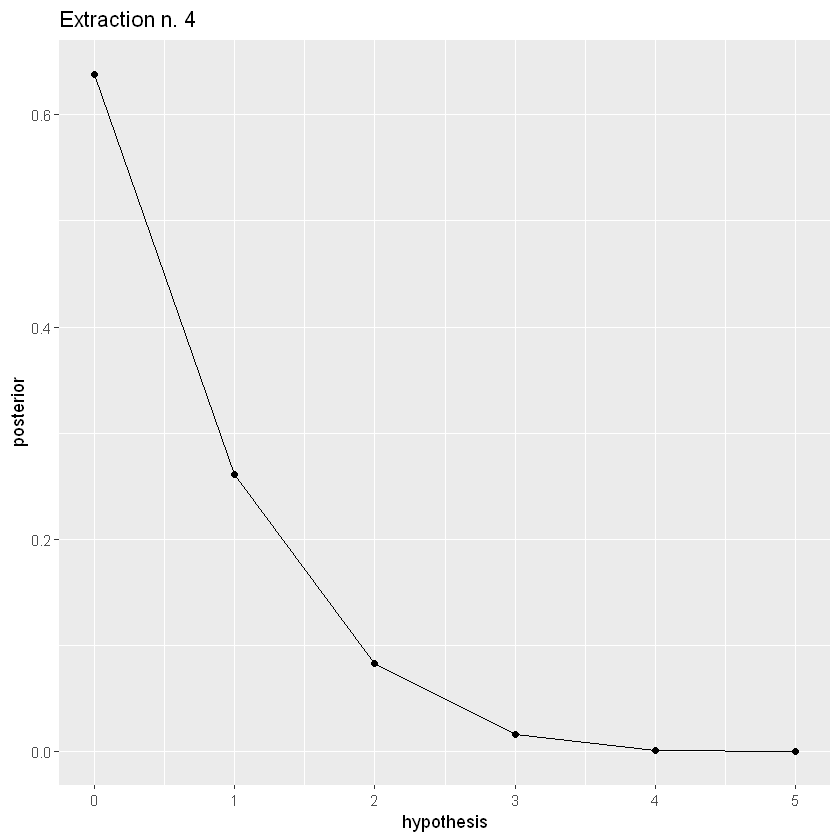

In [140]:
plot.check <- FALSE #TRUE

proceed <- TRUE
prior <- rep(1, times = 6)/6

df <- data.frame(matrix(0, nrow = 1, ncol = 6))
for (i in 0:5) names(df)[i+1] <- sprintf("H%d",i) 
df[1,] <- prior
extracted.colors.history <- c(NA)

#x11()
while (proceed) {
    v <- get.user.input()
    extracted.color <- v[1]; proceed <- v[2]
    #print(x)
    if (!is.na(extracted.color)) {
        prior <- unlist(tail(df, 1)) # running prior
        posterior <- compute.posterior(prior, data = extracted.color) # spezzato per chiarezza
        
        new.row.index <- length(unlist(df[1]))+1
        df[new.row.index,] <- posterior
        print("running posterior:")
        print(posterior); flush.console()
        extracted.colors.history[new.row.index] <- extracted.color
        if (plot.check) print(plot.posterior(posterior, new.row.index-1)) # https://stackoverflow.com/questions/15678261/ggplot-does-not-work-if-it-is-inside-a-for-loop-although-it-works-outside-of-it
    }
}

event.col <- rep(NA, times = new.row.index)
event.col[extracted.colors.history == 1] = "B"
event.col[extracted.colors.history == 0] = "W"

print("Inference history:")
cbind(E = event.col, df)
plot.posterior(posterior, new.row.index-1)

# Exercise 2: six boxes toy model - simulation (i.e. no user input)

[1] "The unknown box contains 3 white balls and 2 black balls (hypothesis H3)"
[1] "Simulating 10 draws"
[1] "white ball extracted"
[1] "white ball extracted"
[1] "black ball extracted"
[1] "black ball extracted"
[1] "white ball extracted"
[1] "white ball extracted"
[1] "white ball extracted"
[1] "white ball extracted"
[1] "black ball extracted"
[1] "white ball extracted"
[1] "Inference history:"


,E,H0,H1,H2,H3,H4,H5
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NA,0.1666667,0.166666667,0.16666667,0.1666667,0.1666667,0.1666667
2,W,0.0000000,0.066666667,0.13333333,0.2000000,0.2666667,0.3333333
3,W,0.0000000,0.018181818,0.07272727,0.1636364,0.2909091,0.4545455
4,B,0.0000000,0.080000000,0.24000000,0.3600000,0.3200000,0.0000000
5,B,0.0000000,0.153846154,0.34615385,0.3461538,0.1538462,0.0000000
6,W,0.0000000,0.061538462,0.27692308,0.4153846,0.2461538,0.0000000
7,W,0.0000000,0.021621622,0.19459459,0.4378378,0.3459459,0.0000000
8,W,0.0000000,0.006956522,0.12521739,0.4226087,0.4452174,0.0000000
9,W,0.0000000,0.002104156,0.07574961,0.3834824,0.5386639,0.0000000


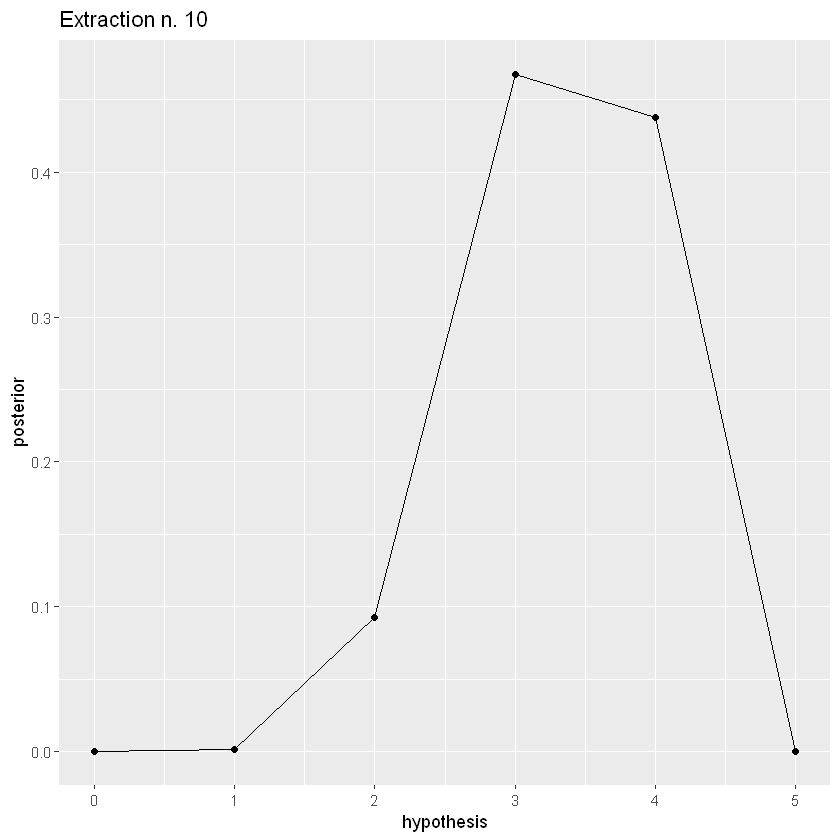

In [142]:
set.seed(1234)

n.white <- sample(0:5)[1]
print(sprintf("The unknown box contains %d white balls and %d black balls (hypothesis H%d)", n.white, (5-n.white), n.white))
box <- c(rep(0, times = n.white), rep(1, times = 5-n.white))
#box
rbox <- function(box) sample(box)[1]
#rbox(box)
colors.array <- c("white", "black")

prior <- rep(1, times = 6)/6
df <- data.frame(matrix(0, nrow = 1, ncol = 6))
for (i in 0:5) names(df)[i+1] <- sprintf("H%d",i) 
df[1,] <- prior

verbose <- FALSE #TRUE
plot.check <- FALSE

n.draws <- 10
print(sprintf("Simulating %d draws", n.draws))
if (verbose) {
    print("prior:")
    print(prior)
} 

extracted.colors.history <- c(NA)

for (i in 1:10) {
    extracted.color <- rbox(box)
    extracted.colors.history[i+1] <- extracted.color
    print(sprintf("%s ball extracted", colors.array[extracted.color+1]))
    
    prior <- unlist(tail(df, 1)) # running prior
    posterior <- compute.posterior(prior, data = extracted.color) # spezzato per chiarezza
    df[length(unlist(df[1]))+1,] <- posterior
    
    if (plot.check) print(plot.posterior(posterior, i))
    
    if (verbose) {
        print("running posterior:")
        print(posterior)
    }
}

event.col <- rep(NA, times = length(extracted.colors.history))
event.col[extracted.colors.history == 1] = "B"
event.col[extracted.colors.history == 0] = "W"

print("Inference history:")
cbind(E = event.col, df)

plot.posterior(posterior, n.draws)

# Exercise 3: sampling from the Erlang distribution
There are multiple ways to do this, of which I list 3:
- we can use the `rgamma` base R function, since the Erlang distribution is just a special case of the Gamma one;
- we can use general-purpose algorithms, like inverse sampling or rejection sampling;
- we can exploit the reproductive property.      

The last option simply means that if $u_i \sim U(]0,1]), \ i = 1,\dots,k$ and we want to compute $x \sim E(k,\lambda)$ then it suffices to use the following formula (cfr [here](https://en.wikipedia.org/wiki/Erlang_distribution)):
\begin{equation}
  x = -\frac{1}{\lambda} \sum_{i=1}^k \ln u_i
\end{equation}
where $k$ and $\lambda$ are the Erlang distribution *shape* and *rate* parameters, respectively.

In [165]:
f <- function(x) return(perlang(x, rate = lambda, shape = k))
f(1:5)

[1] 0.367879441 0.135335283 0.049787068 0.018315639 0.006737947

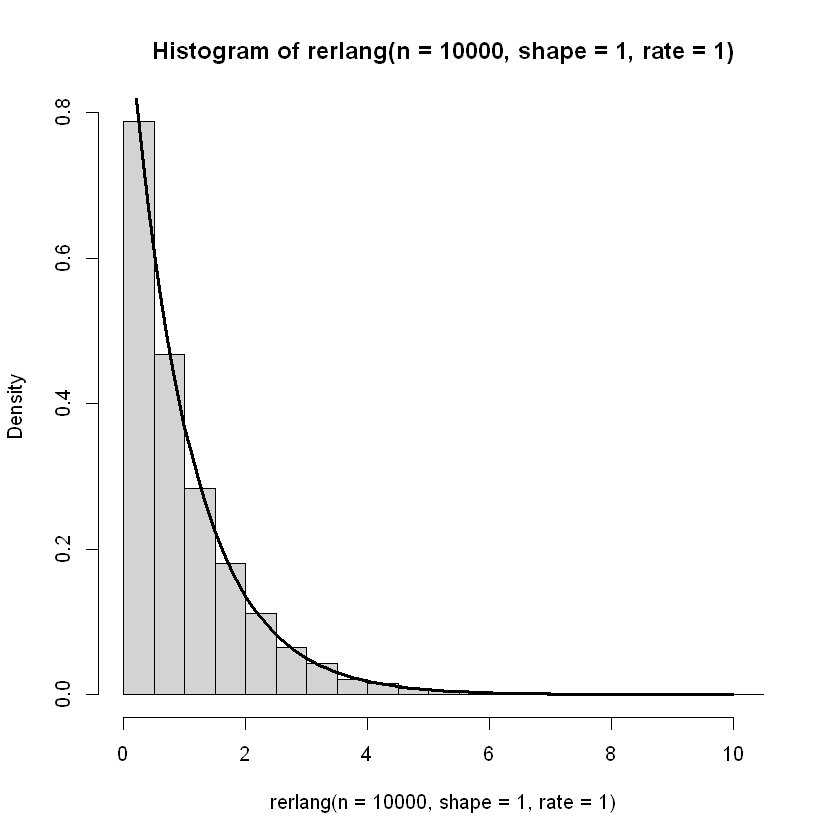

In [2]:
rerlang <- function(n, shape, rate) {
    x <- rep(0, times = n)
    for (i in 1:n) x[i] <- -1/rate*sum(log(runif(shape))) # a faster, vectorized implementation would consist in generating shape*n uniform samples and summing them in groups of shape size. This is easier, though!
    return (x)
}


# To check this works we sample a bunch of numbers and compare the histogram with the PDF
perlang <- function(x, shape, rate) return (rate^shape*x^(shape-1)*exp(-rate*x)/factorial(k-1))
perlang11 <- function(x) return (perlang(x, 1, 1))

k <- 1; lambda <- 1
#hist(rerlang(100000, shape = k, rate = lambda), freq = FALSE)
hist(rerlang(n = 10000, shape = 1, rate = 1), freq = FALSE)
curve(perlang11, from = 0, to = 10, add = TRUE, lwd = 3)

# Exercise 4: Middle square Von Neumann algorithm
**Algorithm**: to generate random number according to this method we proceed as follows. 
- First we choose a *seed* (the first number of the pseudorandom sequence, which is an input to the algorithm) made up of $n$ digits - where *$n$ must be an even number*; 
- then we square it to obtain a number with $2n$ digits (if there are less than $2n$ digits we pad it with leading zeros);
- then we keep the $n$ digits in the middle, and the result is a) a member of the pseudorandom sequence and b) the seed of the following algorithm iteration.     

There above procedure is made nontrivial only by the fact that numbers can't be indexed like vectors. How can we pick individual digits from an integer input, then? There are at least two ways. 
- *Approach 1*: we cheat! We cast our input to `character` (using `as.character`), then split it to a list containing individual characters i.e. digits (using `strsplit`), then cast this list to vector type (using `unlist`). Now we can easily remove the first and the last $n/2$ elements; it suffices to index this vector with `-c((1:n/2),((3*n/2)+1):(2*n))`, since this means we're removing elements `1:n/2` and elements `(n/2+n+1):(2*n)` (which we do in order to keep `n` elements between the leading and trailing `n/2`, i.e. the `n` elements following the first `n/2`). Also notice that we guarantee our vector has $2n$ elements by zero-padding it at the beginning if needed.
- *Approach 2*: we exploit the decimal number system. Let's say $x = 12345$; if we divide and multiply $x$ by $100$ nothing changes, of course, but if before multiplying by $100$ again we remove the decimal part (using `floor`) then we will obtain $\texttt{floor}(123.45)*100 = 123*100 = 12300$ - and hence we successfully removed the last 2 digits! This explains how we can remove the last $n/2$ digits, but what about the first ones? It suffices to recycle the same strategy as follows. Let's say we want to keep the last $d$ digits of an integer number; if we remove them using the above method, then multiply the result by $10^d$, then subtract this from the original number then we're done. Example: say $x=12345$ and $d=3$. By removing the last $d$ digits we obtain $12$, which multiplied by $10^d$ equals $12000$; now since $12345 - 12000 = 345$ we're done.    


Approach #2 is better because a) it doesn't involve lists and conversions back and forth to `chr`, which means it's potentially faster, and b) it removes the need to check for missing digits and zero-padding if needed (since we're just moving the floating point by a set number of places, independently of number "length"). These advantages come at the expense of a conceptually more complicated method (approach #1 replicates what a human would do to manually implement the Von Neumann algorithm); hence I'm implementing them both.

In [101]:
# First let's write some utility functions. In the above cell we already explained that strsplit(as.character(x), "") returns a list of characters such that each element is one of x's digits; if we unlist this we obtain a vector,
# whose length is easily computed. To reverse this operation (i.e. to go from a vector of characters to a number made up of those digits) it suffices to concatenate the chr array into a single chr (using paste) and then
# cast to num type using as.numeric

length.digits             <- function(x) return (length(unlist(strsplit(as.character(x), ""))))
as.chr.vector             <- function(x) return (unlist(strsplit(as.character(x), "")))
as.num.vec.from.chr.array <- function(x) return (as.numeric(paste(x, collapse = "")))

middle.square.generator <- function(N, seed = 1234) {
    x <- seed
    n <- length.digits(x) # this is the n that decides how many digits to drop/keep
    output <- rep(NA, times = N)
    for (i in 1:N) {
        y <- as.chr.vector(x^2) # the digits of x^2
        l <- length(y)
        if (l < 2*n) z <- c(rep("0", times = (2*n-l)), y) # if x^2 doesn't have 2n digits we add enough zeros at the beginning
        else z <- y # otherwise we don't modify it
        a <- as.num.vec.from.chr.array(z[-c((1:n/2), ((3*n/2)+1):(2*n))]) # now we remove the unwanted digits (see cell above for an explanation of these numbers) and reassemble the integer number
        output[i] <- a
        x <- a # the output we just computed is used as the seed of the next algorithm iteration
    }
    return (output)
}

print(middle.square.generator(10))

 [1] 5227 3215 3362 3030 1809 2724 4201 6484  422 1780


In [102]:
# Once again we first write some utility functions. As explained above the appropriate multiplication/division by 10^some.number can be used to discard unwanted leading/trailing digits, so it should be pretty clear
# what the following functions do. Notice that to properly discard digits after a number's floating point we need to use floor, since this function returns the largest integer not larger than its argument
# (which is exactly what we need; removing the decimal part returns exactly this integer). This is important because functions like round, trunc, ceiling do slightly different things and hence may introduce bugs

remove.last.n.digits.from.integer <- function(x, n.digits) return (floor(x/10^n.digits)) # floor = largest int not greater than argument (avoid ceiling, round or trunc)
keep.last.n.digits.of.integer     <- function(x, n.digits) {
    a <- remove.last.n.digits.from.integer(x, n.digits)*10^n.digits
    return (x-a)
}

middle.square.generator.numeric <- function(N, seed = 1234) {
    x <- seed 
    n <- length.digits(x) # as before this is the n mentioned in the "theoretical" algorithm explanation
    output <- rep(NA, times = N)
    for (i in 1:N) {   
       output[i] <- keep.last.n.digits.of.integer(remove.last.n.digits.from.integer(x^2, n.digits = n/2), n.digits = n) # we discard the last n/2 digits, then keep the last n ones
       x <- output[i] # once again: the output of iteration i is the seed for iteration i+1
    }
    return (output)
}

print(middle.square.generator.numeric(10))
print(middle.square.generator(10) == middle.square.generator.numeric(10)) # a check to compare the 2 functions

 [1] 5227 3215 3362 3030 1809 2724 4201 6484  422 1780
 [1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
